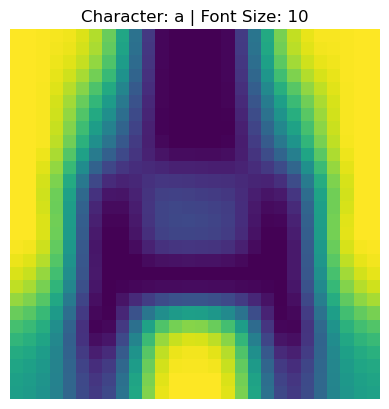

In [1]:
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import cv2
import random
import string
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")

def collect_font_files(fonts_dir):
    '''
    Сбор файлов шрифтов из указанной директории.
    
    Args:
    fonts_dir (str): Путь к директории с файлами шрифтов.
    
    Returns:
    list: Список путей к файлам шрифтов (.ttf и .otf).
    '''
    font_files = []
    for root, dirs, files in os.walk(fonts_dir):
        for file in files:
            if file.endswith(".ttf") or file.endswith(".otf"):
                font_files.append(os.path.join(root, file))
    return font_files

def generate_dataset(fonts, output_dir="dataset", num_images=100, img_size=(1024, 128)):
    '''
    Генерация изображений строк с использованием различных шрифтов и сохранение их в файлы.
    
    Args:
    fonts (list): Список файлов шрифтов.
    output_dir (str): Директория для сохранения изображений.
    num_images (int): Количество изображений для генерации на каждый шрифт.
    img_size (tuple): Размер изображения (ширина, высота).
    '''
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)  # Создаем папку, если ее нет

    for font_file in fonts:
        font_name = os.path.splitext(os.path.basename(font_file))[0]  # Имя шрифта без расширения
        font_output_dir = os.path.join(output_dir, font_name)  # Папка для сохранения изображений для данного шрифта
        if not os.path.exists(font_output_dir):
            os.makedirs(font_output_dir)  # Создаем папку, если ее нет

        for i in range(num_images):
            text = random_string(random.randint(1, 15))  # Генерируем случайную строку текстом
            image = Image.new("L", img_size, color=255)  # Создаем новое изображение
            draw = ImageDraw.Draw(image)
            font_size = random.randint(10, 80)  # Выбираем случайный размер шрифта
            font = ImageFont.truetype(font_file, size=font_size)  # Задаем шрифт
            text_width, text_height = draw.textsize(text, font=font)
            # Центрирование текста на изображении
            x = (img_size[0] - text_width) / 2
            y = (img_size[1] - text_height) / 2
            draw.text((x, y), text, font=font, fill=0)  # Рисуем текст на изображении
            image_path = os.path.join(font_output_dir, f"{font_name}_{i}.png")  # Путь для сохранения изображения
            image.save(image_path)  # Сохраняем изображение


def random_string(length):
    '''
    Вспомогательная функция:
    Генерация случайной строки из латинских букв и цифр.
    
    Args:
    length (int): Длина генерируемой строки.
    
    Returns:
    str: Сгенерированная строка.
    '''
    letters = string.ascii_letters + string.digits
    return ''.join(random.choice(letters) for i in range(length))

def generate_chars(fonts, characters, img_size=(128, 128), min_font_size=10, max_font_size=80, output_dir="chars_samples"):
    '''
    Генерация выборки с символами латинского алфавита (прописными и заглавными) и цифрами различных размеров.
    
    Args:
    fonts (list): Список файлов шрифтов.
    characters (str): Список символов алфавита и цифр.
    img_size (tuple): Размер изображения (ширина, высота).
    min_font_size (int): Минимальный размер шрифта.
    max_font_size (int): Максимальный размер шрифта.
    output_dir (str): Директория для сохранения изображений.
    
    Returns:
    tuple: массив numpy изображений символов и массив меток соответствующих шрифтов.
    '''
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    mark = True
    char_images = []
    char_labels = []
    for font_file in fonts:
        font_name = os.path.splitext(os.path.basename(font_file))[0]  # Имя шрифта без расширения
        font_output_dir = os.path.join(output_dir, font_name)  # Папка для сохранения изображений для данного шрифта
        if not os.path.exists(font_output_dir):
            os.makedirs(font_output_dir)

        for font_size in range(min_font_size, max_font_size + 1):  # Итерируем через каждый размер шрифта
            font = ImageFont.truetype(font_file, size=font_size)
            for i, char in enumerate(characters):
                image = Image.new("L", img_size, color=255)
                draw = ImageDraw.Draw(image)
                bbox = draw.textbbox((0, 0), char, font=font)
                # Вычисляем позицию для центрирования текста
                text_width = bbox[2] - bbox[0]
                text_height = bbox[3] - bbox[1]
                x = (img_size[0] - text_width) // 2
                y = (img_size[1] - text_height) // 2
                draw.text((x, y), char, font=font, fill=0)  # Рисуем символ центрированно
                image_path = os.path.join(font_output_dir, f"{char}_{font_size}_{i}.png")  # Путь для сохранения изображения
                image.save(image_path)  # Сохраняем изображение
                
                # Контур и обрезка символа на изображении
                contours = find_contours(image)
                symbols = extract_symbols(image, contours)
                for symbol in symbols:
                    char_images.append(symbol)
                    char_labels.append(font_name)
                
                # Визуалиция вырезанного символа
                if mark == True:
                    plt.imshow(symbol)
                    plt.title(f'Character: {char} | Font Size: {font_size}')
                    plt.axis('off')
                    plt.show()
                    mark = False

    return np.array(char_images), np.array(char_labels)


def find_contours(char_image):
    '''
    Вспомогательная функция:
    Поиск контуров в изображении для выделения отдельных символов.
    Использована в генерации датасета, так как в результате она используется в модуле предсказания. 
    
    Args:
    char_image (Image): Изображение, из которого необходимо извлечь контуры.
    
    Returns:
    list: Список прямоугольников, описывающих найденные контуры.
    '''
    im_array = np.array(char_image)
    if len(im_array.shape) == 3:
        im_gray = cv2.cvtColor(im_array, cv2.COLOR_RGB2GRAY)
    else:
        im_gray = im_array

    im_th = cv2.adaptiveThreshold(im_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY_INV, 11, 2)
    ctrs, _ = cv2.findContours(im_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [cv2.boundingRect(ctr) for ctr in ctrs]
    return contours

def extract_symbols(char_image, contours):
    '''
    Вспомогательная функция:
    Выделение символов из строки по найденным контурам.
    Использована в генерации датасета, так как в результате она используется в модуле предсказания. 
    
    Args:
    char_image (Image): Изображение строки.
    contours (list): Список контуров символов.
    
    Returns:
    list: Список изображений выделенных символов.
    '''
    symbols = []
    for (x, y, w, h) in contours:
        symbol = char_image.crop((x, y, x + w, y + h))
        symbol = symbol.resize((28, 28))
        symbols.append(np.array(symbol))
    return symbols


# Путь к директории с шрифтами
fonts_dir = "fonts"

# Сбор файлов шрифтов
fonts = collect_font_files(fonts_dir)

# Генерация dataset и меток
generate_dataset(fonts)

# Список символов для обучающей и тестовой выборок
characters = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

# Генерируем изображения символов и меток
images, labels = generate_chars(fonts, characters)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Сохранение обучающую и тестовую выборки
np.savez("fonts_dataset.npz", X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, labels=labels)